This file is based on "5.5-Generate DataFrame for front-end.ipynb"

1. Load libraries

In [1]:
from PIL import Image
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import umap

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm

# Use IoU instead
# import re
from scipy.spatial.distance import cdist
from skimage.transform import resize

d:\zsh\graduation\grad_env_take_2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###### 2. Decide the procedure by grouping the different columns together

For cityscapes and synthia separately (and then concatenate):

* name, image_path, dataset

* label_path:
    * first get labels (in class format)
        * for synthia, need to transform to class format specifically
            * for calculating similarity
        * also from class to color as well, because use the color of cityscapes
            * for saving the label and getting the label path
        * get the saved path and save it in a list
    
* similar_image_paths，similar_IoU_score (Note: called IoU_score originally): finding the most similar masks from another dataset
* Generate from os list of images:
    * class distribution
        * (other_ratio, road_ratio, sidewalk_ratio, vegetation_ratio, sky_ratio, car_ratio)
    * embedding of input (originally: tsne_1, tsne_2)
        simple dimensionality reduction (simple_tsne_1,simple_tsne_2)
        and also the embedding from classification model(meaningful_tsne_1,meaningful_tsne_1)
* bottleneck_activations_embedding, prediction_path, and performance
    * save output locally, and then add path (prediction_path)
    * performance: (other_IoU, road_IoU, sidewalk_IoU, vegetation_IoU, sky_IoU, car_IoU)

**Make sure that the column names are the same as current！！！**

**Remember to also save id**

# name, image_path, dataset

In [2]:
# path of the image folders for the model
image_path_cityscapes = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\original_cityscapes_inputs" # 500 images in total
image_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\image" # 9400 images in total

# path of image folders for displaying in the system

start = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image"
relative_img_path_cityscapes = os.path.relpath(image_path_cityscapes, start)
relative_img_path_synthia = os.path.relpath(image_path_synthia, start)

In [1]:
sample_number = 10

In [4]:
cityscapes_names= os.listdir(image_path_cityscapes)
random.seed(55)
cityscapes_names_sample = random.sample(cityscapes_names,sample_number)

synthia_names = os.listdir(image_path_synthia)
# randomly select 100 images to load in to numpy array
random.seed(55)
synthia_names_sample = random.sample(synthia_names,sample_number)

In [6]:
# Cityscapes
cityscapes_initial_info = [] # include name, image path and dataset name
cityscapes_img_sample = []

for name in cityscapes_names_sample:
    image = Image.open(image_path_cityscapes+"\\"+name).convert("RGB")
    image_path = relative_img_path_cityscapes+"\\"+name
    
    cityscapes_img_sample.append(np.array(image))
    cityscapes_initial_info.append((name,image_path,"Cityscapes"))

cityscapes_initial_info = np.array(cityscapes_initial_info)

In [7]:
cityscapes_initial_info[:5]

array([['14.jpeg', 'dataset\\original_cityscapes_inputs\\14.jpeg',
        'Cityscapes'],
       ['87.jpeg', 'dataset\\original_cityscapes_inputs\\87.jpeg',
        'Cityscapes'],
       ['189.jpeg', 'dataset\\original_cityscapes_inputs\\189.jpeg',
        'Cityscapes'],
       ['167.jpeg', 'dataset\\original_cityscapes_inputs\\167.jpeg',
        'Cityscapes'],
       ['439.jpeg', 'dataset\\original_cityscapes_inputs\\439.jpeg',
        'Cityscapes']], dtype='<U43')

In [8]:
# synthia
synthia_initial_info = [] # include name, image path and dataset name
synthia_img_sample = []

for name in synthia_names_sample:
    image = Image.open(image_path_synthia+"\\"+name).convert("RGB")
    image_path = relative_img_path_synthia+"\\"+name
    synthia_initial_info.append((name, image_path,"Synthia"))
    synthia_img_sample.append(np.array(image))

synthia_initial_info = np.array(synthia_initial_info)
synthia_img_sample = np.array(synthia_img_sample)

In [9]:
len(synthia_initial_info)

10

In [10]:
combined_initial_info = np.concatenate((cityscapes_initial_info,synthia_initial_info),axis=0)

In [11]:
df = pd.DataFrame(combined_initial_info,columns = ["name", "image_path","dataset"])

In [13]:
df.head()

,name,image_path,dataset
0,14.jpeg,dataset\original_cityscapes_inputs\14.jpeg,Cityscapes
1,87.jpeg,dataset\original_cityscapes_inputs\87.jpeg,Cityscapes
2,189.jpeg,dataset\original_cityscapes_inputs\189.jpeg,Cityscapes
3,167.jpeg,dataset\original_cityscapes_inputs\167.jpeg,Cityscapes
4,439.jpeg,dataset\original_cityscapes_inputs\439.jpeg,Cityscapes


# Synthia color transformation code (for later use)

In [14]:
synthia_colors = [[  0,   0,   0], # void
         [70,130, 180], # sky
         [70,70,70], # building
        [128, 64, 128], # road
        [244, 35, 232], # sidewalk
         [64,64,128], # fense
         [107,142,35], # vegetation	
        [153, 153, 153], # pole
        [0, 0, 142], # car
        [220, 220, 0],  # traffic sign
        [220, 20, 60], # pedestrian
        [119, 11, 32], # bicycle
        [0, 0, 230], # motorcycle
        [250,170,160], # parking-slot
        [128,64,64], # road-work
        [250,170,30], # traffic light
        [152, 251, 152], # terrain
        [255, 0, 0], # rider
        [0, 0, 70], # truck
        [0, 60, 100], # bus
        [0, 80, 100], # train
        [102, 102, 156]# wall, lanemarking
    ]


category_map = {
    0: 0,
    1: 4,
    2: 0,
    3: 1,
    4: 2,
    5: 0,
    6: 3,
    7: 0,
    8: 5,
    9: 0,
    10: 0,
    11: 0,
    12: 0,
    13: 0,
    14: 0,
    15: 0,
    16: 0,
    17: 0,
    18: 0,
    19: 0,
    20: 0,
    21: 0}

In [15]:
# color to class
def color_to_class(label):
    # create new empty mask
    mask = np.zeros(shape=(label.shape[0], label.shape[1]), dtype = np.int32)
    # iterate through two dimensions
    for row in range(label.shape[0]):
        for col in range(label.shape[1]):
            a = label[row, col,:]
            # distance between this pixel and the original pixel
            d = cdist(np.array([a]),np.array(synthia_colors))
            idx = np.argmin(d)
            new_idx = category_map[idx]
            mask[row, col] = new_idx
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1]))
    return mask

In [16]:
# Determine the color for classes
colors = [[  0,   0,   0],
          [128, 64, 128],# road
          [244, 35, 232], # sidewalk
          [107, 142, 35],# vegetation
          [70, 130, 180], # sky
          [0, 0, 142], # car
         ]

# class to color: useful for displaying the similar images later
def class_to_color(labels):
    label_colors = np.zeros((256,256,3))
    
    for i,row in enumerate(labels):
        for j,pixel in enumerate(row):
            label_colors[i,j] = colors[pixel]
    
    return label_colors.astype(int)  # make each pixel value an integer to visualize it better

# label_path

Cityscapes labels

In [17]:
# relative paths for cityscapes
cityscpaes_save_labels_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\cityscapes_labels_sample"
cityscapes_label_folder_relative = os.path.relpath(cityscpaes_save_labels_path, start)

**For now: still use the sample of labels. Possibly changing to something else later on**

In [18]:
# labels of cityscapes
pickle_file = os.path.join("D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\\5_classes_preprocessed", "validation_label_classes.pkl")
with open(pickle_file, 'rb') as f:
    Y_test = pickle.load(f)
    
cityscapes_labels = np.array(Y_test)

Generate and save labels for the subset for displaying in the VA system

In [19]:
cityscapes_labels_sample= []
cityscapes_label_path_sample = []

for name in cityscapes_names_sample:
    ind = int(name.split('.')[0]) # get the cityscapes index based on names
    label = cityscapes_labels[ind] # get corresponding labels based on indices
    label_path = cityscapes_label_folder_relative+"\\"+name
    
    cityscapes_labels_sample.append(label)
    cityscapes_label_path_sample.append(label_path)

cityscapes_labels_sample = np.array(cityscapes_labels_sample)
cityscapes_label_path_sample = np.array(cityscapes_label_path_sample)

In [20]:
for i in range(sample_number):
    name = cityscapes_names_sample[i]
    label = cityscapes_labels_sample[i]
    label_color = class_to_color(label)
    label_image = Image.fromarray(label_color.astype(np.uint8))
    label_image.save(cityscpaes_save_labels_path+"\\"+name)

In [21]:
cityscapes_label_path_sample.shape

(10,)

Synthia labels

In [22]:
synthia_label_original_folder = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\label-rgb"
synthia_save_labels_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\\new_labels"
synthia_label_folder_relative = os.path.relpath(synthia_save_labels_path, start)

In [42]:
# def transform_masks_synthia(labels):
#     masks = []
#     for label in labels:
#         mask = color_to_class(label)
#         masks.append(mask)
#     masks = np.array(masks)

#     return masks

Note: comment out the corresponding lines if loading the synthia_labels_sample.pkl

In [23]:
# this usually takes a long time
synthia_labels_sample= []
synthia_label_path_sample = []

for name in synthia_names_sample:
    # transform the color encoding from 20 classes to 6 classes
    original_label_rgb = Image.open(synthia_label_original_folder+"\\"+name).convert("RGB")
    original_label_rgb = np.array(original_label_rgb)
    label = color_to_class(original_label_rgb)
    resized_label_rgb = class_to_color(label)
    label_path =synthia_label_folder_relative+"\\"+name
    resized_label_rgb = Image.fromarray(resized_label_rgb.astype(np.uint8))
    
#     save the new labels
    resized_label_rgb.save(synthia_save_labels_path+"\\"+name)
    
    synthia_labels_sample.append(label)
    synthia_label_path_sample.append(label_path)

synthia_labels_sample = np.array(synthia_labels_sample)
synthia_label_path_sample = np.array(synthia_label_path_sample)

In [24]:
len(synthia_label_path_sample)

10

save the synthia masks in a pickle to save effort

In [32]:
# with open('synthia_labels_sample.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(synthia_labels_sample, file)

# with open('synthia_labels_sample.pkl', 'rb') as f:
#     synthia_labels_sample = pickle.load(f)

In [25]:
synthia_labels_sample.shape

(10, 256, 256)

Combine cityscapes_label_path_sample and synthia_label_path_sample

In [26]:
label_path_sample = np.concatenate((cityscapes_label_path_sample,synthia_label_path_sample),axis = 0)

In [27]:
df["label_path"] = label_path_sample

In [29]:
df.iloc[5:15]

,name,image_path,dataset,label_path
5,237.jpeg,dataset\original_cityscapes_inputs\237.jpeg,Cityscapes,dataset\cityscapes_labels_sample\237.jpeg
6,486.jpeg,dataset\original_cityscapes_inputs\486.jpeg,Cityscapes,dataset\cityscapes_labels_sample\486.jpeg
7,134.jpeg,dataset\original_cityscapes_inputs\134.jpeg,Cityscapes,dataset\cityscapes_labels_sample\134.jpeg
8,442.jpeg,dataset\original_cityscapes_inputs\442.jpeg,Cityscapes,dataset\cityscapes_labels_sample\442.jpeg
9,183.jpeg,dataset\original_cityscapes_inputs\183.jpeg,Cityscapes,dataset\cityscapes_labels_sample\183.jpeg
10,0001480.png,dataset\SYNTHIA_256\image\0001480.png,Synthia,dataset\SYNTHIA_256\new_labels\0001480.png
11,0003215.png,dataset\SYNTHIA_256\image\0003215.png,Synthia,dataset\SYNTHIA_256\new_labels\0003215.png
12,0002457.png,dataset\SYNTHIA_256\image\0002457.png,Synthia,dataset\SYNTHIA_256\new_labels\0002457.png
13,0004959.png,dataset\SYNTHIA_256\image\0004959.png,Synthia,dataset\SYNTHIA_256\new_labels\0004959.png
14,0001305.png,dataset\SYNTHIA_256\image\0001305.png,Synthia,dataset\SYNTHIA_256\new_labels\0001305.png


# similar_image_paths，similar_IoU_score 
(Note: called IoU_score originally): finding the most similar masks from another dataset

In [30]:
# find the most similar mask from another dataset to the current image mask
def most_similar_mask(instance, data,mode = "IoU"):
#     nodes = np.asarray(nodes)
    # Euclidean distance calculation
    if mode == "IoU":
        iou_list = []
        for new_instance in data:
#             the original IoU methods were not good because when both class is 0, the intersection won't count it
#             intersection = np.logical_and(instance, new_instance)
#             union = np.logical_or(instance, new_instance)
            intersection = len(np.where(instance == new_instance)[0])
            union = instance.shape[0]*instance.shape[1]
#             print(intersection)
#             print(union)
            iou_score = intersection / union
            iou_list.append(iou_score)
        iou_arr = np.array(iou_list)
        best_index = np.argmax(iou_arr)
        best_score = iou_arr[best_index]
    
    return best_index, best_score

In [38]:
# find all the corresponding paths and similar scores for the most similar masks of the CITYSCAPES images
cityscapes_similar_image_paths = []
cityscapes_similar_scores = []

for label in cityscapes_labels_sample:
    image_index_synthia,similar_score = most_similar_mask(label,synthia_labels_sample)
    similar_image_path = synthia_initial_info[image_index_synthia][1]
    
    cityscapes_similar_image_paths.append(similar_image_path)
    cityscapes_similar_scores.append(similar_score)

cityscapes_similar_image_paths = np.array(cityscapes_similar_image_paths)
cityscapes_similar_scores = np.array(cityscapes_similar_scores)

In [39]:
# find all the corresponding paths and similar scores for the most similar masks of the SYNTHIA images
synthia_similar_image_paths = []
synthia_similar_scores = []

for label in synthia_labels_sample:
    image_index_cityscapes,similar_score = most_similar_mask(label,cityscapes_labels_sample)
    similar_image_path = cityscapes_initial_info[image_index_cityscapes][1]
    
    synthia_similar_image_paths.append(similar_image_path)
    synthia_similar_scores.append(similar_score)

synthia_similar_image_paths = np.array(synthia_similar_image_paths)
synthia_similar_scores = np.array(synthia_similar_scores)

In [40]:
similar_image_paths =  np.concatenate((cityscapes_similar_image_paths,synthia_similar_image_paths),axis = 0)
similar_scores = np.concatenate((cityscapes_similar_scores,synthia_similar_scores),axis = 0)

In [41]:
df["similar_image_paths"] = similar_image_paths
df["similar_IoU_score"]=similar_scores

In [43]:
# df.iloc[495:505]
df.iloc[5:15]

,name,image_path,dataset,label_path,similar_image_paths,similar_IoU_score
5,237.jpeg,dataset\original_cityscapes_inputs\237.jpeg,Cityscapes,dataset\cityscapes_labels_sample\237.jpeg,dataset\SYNTHIA_256\image\0001480.png,0.435898
6,486.jpeg,dataset\original_cityscapes_inputs\486.jpeg,Cityscapes,dataset\cityscapes_labels_sample\486.jpeg,dataset\SYNTHIA_256\image\0004946.png,0.474365
7,134.jpeg,dataset\original_cityscapes_inputs\134.jpeg,Cityscapes,dataset\cityscapes_labels_sample\134.jpeg,dataset\SYNTHIA_256\image\0004946.png,0.451935
8,442.jpeg,dataset\original_cityscapes_inputs\442.jpeg,Cityscapes,dataset\cityscapes_labels_sample\442.jpeg,dataset\SYNTHIA_256\image\0001305.png,0.362625
9,183.jpeg,dataset\original_cityscapes_inputs\183.jpeg,Cityscapes,dataset\cityscapes_labels_sample\183.jpeg,dataset\SYNTHIA_256\image\0004946.png,0.359467
10,0001480.png,dataset\SYNTHIA_256\image\0001480.png,Synthia,dataset\SYNTHIA_256\new_labels\0001480.png,dataset\original_cityscapes_inputs\237.jpeg,0.435898
11,0003215.png,dataset\SYNTHIA_256\image\0003215.png,Synthia,dataset\SYNTHIA_256\new_labels\0003215.png,dataset\original_cityscapes_inputs\134.jpeg,0.390427
12,0002457.png,dataset\SYNTHIA_256\image\0002457.png,Synthia,dataset\SYNTHIA_256\new_labels\0002457.png,dataset\original_cityscapes_inputs\189.jpeg,0.336685
13,0004959.png,dataset\SYNTHIA_256\image\0004959.png,Synthia,dataset\SYNTHIA_256\new_labels\0004959.png,dataset\original_cityscapes_inputs\189.jpeg,0.478058
14,0001305.png,dataset\SYNTHIA_256\image\0001305.png,Synthia,dataset\SYNTHIA_256\new_labels\0001305.png,dataset\original_cityscapes_inputs\442.jpeg,0.362625


In [92]:
# df.to_csv("system_df_full.csv",index=True)

# generate from list of images and labels

* class distribution
    * (other_ratio, road_ratio, sidewalk_ratio, vegetation_ratio, sky_ratio, car_ratio)
* embedding of input (originally: tsne_1, tsne_2)
    * simple dimensionality reduction (simple_tsne_1,simple_tsne_2)
    * and also the embedding from classification model(meaningful_tsne_1,meaningful_tsne_1)

Load images to data loader

In [44]:
class CityscapesDataset(Dataset):
    
    def __init__(self, images, labels, noise_level = 0):
        self.images = images
        self.labels = labels
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        # helps to change the noise level
        if self.noise_level!=0:
            image = image+(self.noise_level*np.random.normal(0, (image.max() - image.min()), image.shape)).astype("uint8") # (mean, sigma, image_shape)
        image = self.transform(image)
        label = torch.from_numpy(label).long()
        return image, label
        
    def transform(self, image):
        # normalization
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # normalize to control the "dynamic range" of activations of different layers
        ])
        return transform_ops(image)

In [46]:
repo_path = "D:\zsh\graduation\\Graduation-project-domain-shift-image-2-image"
# cityscapes_label_path = "dataset\\cityscapes_labels_100"
cityscapes_images = []
cityscapes_labels = []
synthia_images = []
synthia_labels = []

# get the corresponding images and labels for the dataloader
for index,path in enumerate(df["image_path"]):
    full_path = os.path.join(repo_path,path)
    dataset = df["dataset"].iloc[index]
    # parse to get the name of image
    name = os.path.split(path)[1]
    label_index = int(name.split(".")[0])
    if dataset == "Cityscapes":
        # image
        img = Image.open(full_path)
        img = np.array(img)
        # label
        label = Y_test[label_index]
        label = np.array(label)
        cityscapes_images.append(img)
        cityscapes_labels.append(label)
    elif dataset == "Synthia":
        # image
        img = Image.open(full_path)
        img = np.array(img)
        # label
        label = synthia_labels_sample[index-sample_number]
        label = np.array(label)
        synthia_images.append(img)
        synthia_labels.append(label)
    

In [47]:
cityscapes_images = np.array(cityscapes_images)
cityscapes_labels = np.array(cityscapes_labels)
synthia_images = np.array(synthia_images)
synthia_labels = np.array(synthia_labels)

print(synthia_images.shape)
print(synthia_images.shape)


(10, 256, 256, 3)
(10, 256, 256, 3)


In [48]:
# load to Dataset class and DataLoader
batch_size = 1
cityscapes_dataset = CityscapesDataset(cityscapes_images, cityscapes_labels,noise_level=0) # no noise for this comparison
cityscapes_loader = DataLoader(cityscapes_dataset, batch_size=batch_size)

synthia_dataset = CityscapesDataset(synthia_images, synthia_labels,noise_level=0)
synthia_loader = DataLoader(synthia_dataset, batch_size=batch_size)

**class distribution**

In [49]:
# get the ratio for each class
def get_class_distribution(labels):
    class_dist = []
    for label in labels:
        class_for_label = []
        for i in range(6):
            element_count = np.count_nonzero(label==i)
            class_for_label.append(element_count/(256*256))
        class_dist.append(class_for_label)
        class_for_label= class_for_label# change to another size if the image size is changed
    class_dist = np.array(class_dist)
    return class_dist

In [50]:
cityscpaes_class_dist = get_class_distribution(cityscapes_labels)
# synthia_labels
synthia_class_dist = get_class_distribution(synthia_labels)

In [51]:
print(cityscpaes_class_dist.shape)
print(synthia_class_dist.shape)

(10, 6)
(10, 6)


In [53]:
class_dist = np.concatenate((cityscpaes_class_dist,synthia_class_dist),axis=0)

In [54]:
class_dist_df = pd.DataFrame(class_dist,columns=["other_ratio","road_ratio","sidewalk_ratio","vegetation_ratio","sky_ratio","car_ratio"])
class_dist_df.head()

,other_ratio,road_ratio,sidewalk_ratio,vegetation_ratio,sky_ratio,car_ratio
0,0.268173,0.380219,0.054855,0.259460,0.026566,0.010727
1,0.390427,0.322311,0.000000,0.128143,0.004623,0.154495
2,0.615875,0.264603,0.010590,0.037872,0.023697,0.047363
3,0.235931,0.296295,0.021698,0.421646,0.023544,0.000885
4,0.501968,0.312622,0.026047,0.157547,0.000031,0.001785


In [55]:
df_full = pd.concat((df,class_dist_df),axis=1)

**embedding of input**

* simple dimensionality reduction (simple_tsne_1,simple_tsne_2)
* and also the embedding from classification model(meaningful_tsne_1,meaningful_tsne_1)

**TODO: change the two tsne to combined with PCA, if necessary**

In [69]:
# simple dimensionality reduction
combined_images = np.concatenate((cityscapes_images,synthia_images),axis=0)
simple_combined_embedding = combined_images.reshape(combined_images.shape[0],-1)
# simple_combined_embedding =np.reshape(combined_images,(len(combined_images), 256*256*3))

# pca_50 = PCA(n_components=50)
# pca_embedding = pca_50.fit_transform(simple_combined_embedding)
# print(np.sum(pca_50.explained_variance_ratio_))
tsne = TSNE()
simple_tsne_embedding = tsne.fit_transform(simple_combined_embedding)
# simple_tsne_embedding = tsne.fit_transform(pca_embedding)


# simple pca embedding
pca = PCA(n_components=2)
simple_pca_embedding = pca.fit_transform(simple_combined_embedding)
print(np.sum(pca.explained_variance_ratio_))

0.412335609776955


In [71]:
# move to the pre-trained model path
cd D:\zsh\graduation\ViTs-vs-CNNs

D:\zsh\graduation\ViTs-vs-CNNs


In [72]:
import torch
import torch.nn as nn
import global_val

from models.ghost_bn import GhostBN2D_ADV
from models.advresnet_gbn_gelu import Affine
import models.advresnet_gbn_gelu as advres
from main_adv_res import EightBN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load weights
classifier_model = advres.__dict__["resnet50"](norm_layer = EightBN)
weights_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\advres50_gelu.pth"
weight_dict = torch.load(weights_path,map_location=device)["model"]

classifier_model.load_state_dict(weight_dict)

<All keys matched successfully>

In [73]:
# move back to orriginal path
cd D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\jupyter

D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\jupyter


In [75]:
# this get the embedding from the pre-trained classification model for one image
def get_representation_for_image(image,label):
    # resize the image and transform it to tensor # [256,256,3] -> [224,224,3] 
    resized_image = resize(image, (224, 224,3))
    resized_image_tensor = torch.from_numpy(resized_image)
    resized_image_tensor = torch.permute(resized_image_tensor, (2, 0, 1))
    resized_image_tensor = resized_image_tensor[None,:] # [3,224,224] -> [1,3,224,224] (because model takes 4D input)
    
    # dictionary for the activations
    activations = {}

    def get_activations(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # use the output of (avgpool) layer because it is the same as the input of last layer
    h = classifier_model.avgpool.register_forward_hook(get_activations("input_last_layer"))

    classifier_model.eval()
    classifier_model.sing=True
    classifier_model.training=False
    out = classifier_model(resized_image_tensor.float(),label)
    
    # remove the hook
    h.remove()

    first_part_embedding = torch.flatten(activations["input_last_layer"][0])
    
    return first_part_embedding

In [76]:
embedding_list = []
for i, image in enumerate(combined_images): # i is not used, could remove the enumerate
    first_part_embedding = get_representation_for_image(image,"__") # y_label is never used for the pretrained model, so just use replacement
    second_part_embedding = class_dist[i] # second part of the embedding is class ratio
    embedding = np.concatenate((first_part_embedding.numpy(),np.array(second_part_embedding)),axis = 0)
    embedding_list.append(embedding)

In [78]:
embedding_arr = np.array(embedding_list)
# pca_50 = PCA(n_components=50)
# pca_embedding = pca_50.fit_transform(embedding_arr)
# print(np.sum(pca_50.explained_variance_ratio_))
# pca = PCA(n_components=2)
tsne = TSNE()
# meaningful_tsne_embedding = tsne.fit_transform(pca_embedding)
meaningful_tsne_embedding = tsne.fit_transform(embedding_arr)

In [79]:
full_embedding = np.concatenate((simple_tsne_embedding,meaningful_tsne_embedding,simple_pca_embedding),axis=1)

In [80]:
df_input_embedding = pd.DataFrame(full_embedding, columns=["simple_tsne_1","simple_tsne_2","meaningful_tsne_1","meaningful_tsne_2","pca_1","pca_2"])

In [81]:
df_input_embedding.head()

,simple_tsne_1,simple_tsne_2,meaningful_tsne_1,meaningful_tsne_2,pca_1,pca_2
0,61.698845,55.318829,-85.283386,-72.167946,503.546415,-3180.000910
1,-12.906113,21.398748,-35.235085,14.135887,7021.621696,-6708.378633
2,26.645414,-58.506546,-182.491776,123.563637,6927.331786,-2858.908411
3,101.314774,-74.139946,-197.710770,-70.297905,-1387.100221,1508.490089
4,69.829346,5.824750,15.701824,-76.754539,1293.309014,-6028.467934


In [82]:
df_full = pd.concat((df_full,df_input_embedding),axis = 1)
df_full.head()

,name,image_path,dataset,label_path,similar_image_paths,similar_IoU_score,other_ratio,road_ratio,sidewalk_ratio,vegetation_ratio,sky_ratio,car_ratio,simple_tsne_1,simple_tsne_2,meaningful_tsne_1,meaningful_tsne_2,pca_1,pca_2
0,14.jpeg,dataset\original_cityscapes_inputs\14.jpeg,Cityscapes,dataset\cityscapes_labels_sample\14.jpeg,dataset\SYNTHIA_256\image\0001305.png,0.353790,0.268173,0.380219,0.054855,0.259460,0.026566,0.010727,61.698845,55.318829,-85.283386,-72.167946,503.546415,-3180.000910
1,87.jpeg,dataset\original_cityscapes_inputs\87.jpeg,Cityscapes,dataset\cityscapes_labels_sample\87.jpeg,dataset\SYNTHIA_256\image\0004946.png,0.351639,0.390427,0.322311,0.000000,0.128143,0.004623,0.154495,-12.906113,21.398748,-35.235085,14.135887,7021.621696,-6708.378633
2,189.jpeg,dataset\original_cityscapes_inputs\189.jpeg,Cityscapes,dataset\cityscapes_labels_sample\189.jpeg,dataset\SYNTHIA_256\image\0004959.png,0.478058,0.615875,0.264603,0.010590,0.037872,0.023697,0.047363,26.645414,-58.506546,-182.491776,123.563637,6927.331786,-2858.908411
3,167.jpeg,dataset\original_cityscapes_inputs\167.jpeg,Cityscapes,dataset\cityscapes_labels_sample\167.jpeg,dataset\SYNTHIA_256\image\0003215.png,0.333984,0.235931,0.296295,0.021698,0.421646,0.023544,0.000885,101.314774,-74.139946,-197.710770,-70.297905,-1387.100221,1508.490089
4,439.jpeg,dataset\original_cityscapes_inputs\439.jpeg,Cityscapes,dataset\cityscapes_labels_sample\439.jpeg,dataset\SYNTHIA_256\image\0005761.png,0.400711,0.501968,0.312622,0.026047,0.157547,0.000031,0.001785,69.829346,5.824750,15.701824,-76.754539,1293.309014,-6028.467934


In [84]:
df_full.to_csv("system_df_small_sample.csv",index=True)

#  bottleneck_activations_embedding, prediction_path, and performance
* save output locally, and then add path (prediction_path)
* performance: (other_IoU, road_IoU, sidewalk_IoU, vegetation_IoU, sky_IoU, car_IoU)
    **How do you get the IoU per class (check original paper)**

Read the data (for updating the bottleneck activations)

In [85]:
df = df_full.copy()

In [86]:
df.head()

,name,image_path,dataset,label_path,similar_image_paths,similar_IoU_score,other_ratio,road_ratio,sidewalk_ratio,vegetation_ratio,sky_ratio,car_ratio,simple_tsne_1,simple_tsne_2,meaningful_tsne_1,meaningful_tsne_2,pca_1,pca_2
0,14.jpeg,dataset\original_cityscapes_inputs\14.jpeg,Cityscapes,dataset\cityscapes_labels_sample\14.jpeg,dataset\SYNTHIA_256\image\0001305.png,0.353790,0.268173,0.380219,0.054855,0.259460,0.026566,0.010727,61.698845,55.318829,-85.283386,-72.167946,503.546415,-3180.000910
1,87.jpeg,dataset\original_cityscapes_inputs\87.jpeg,Cityscapes,dataset\cityscapes_labels_sample\87.jpeg,dataset\SYNTHIA_256\image\0004946.png,0.351639,0.390427,0.322311,0.000000,0.128143,0.004623,0.154495,-12.906113,21.398748,-35.235085,14.135887,7021.621696,-6708.378633
2,189.jpeg,dataset\original_cityscapes_inputs\189.jpeg,Cityscapes,dataset\cityscapes_labels_sample\189.jpeg,dataset\SYNTHIA_256\image\0004959.png,0.478058,0.615875,0.264603,0.010590,0.037872,0.023697,0.047363,26.645414,-58.506546,-182.491776,123.563637,6927.331786,-2858.908411
3,167.jpeg,dataset\original_cityscapes_inputs\167.jpeg,Cityscapes,dataset\cityscapes_labels_sample\167.jpeg,dataset\SYNTHIA_256\image\0003215.png,0.333984,0.235931,0.296295,0.021698,0.421646,0.023544,0.000885,101.314774,-74.139946,-197.710770,-70.297905,-1387.100221,1508.490089
4,439.jpeg,dataset\original_cityscapes_inputs\439.jpeg,Cityscapes,dataset\cityscapes_labels_sample\439.jpeg,dataset\SYNTHIA_256\image\0005761.png,0.400711,0.501968,0.312622,0.026047,0.157547,0.000031,0.001785,69.829346,5.824750,15.701824,-76.754539,1293.309014,-6028.467934


Load model

In [93]:
# model structure of U-Net
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out,middle_out

In [94]:
model_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\5-classes-U-Net-2023-03-09.pth"

device = torch.device('cpu')
model_ = UNet(num_classes=6).to(device)
model_.load_state_dict(torch.load(model_path,map_location=device))

<All keys matched successfully>

In [165]:
def IoU_per_class(prediction,label):
    prediction = prediction.detach().numpy()
    label = label.detach().numpy()
    # Loop over each class
    iou_list = []
    # Flatten label and class arrays
    flat_prediction = prediction.flatten()
    flat_label = label.flatten()

    for i in range(6):
        
        # Calculate intersection and union
        intersection = np.sum((flat_prediction == i) & (flat_label == i))
        union = np.sum((flat_prediction == i) | (flat_label == i))

        # Calculate IoU
        iou = intersection / (union + 1e-12) # prevent infinitiy iou value

        # Store IoU value in dictionary
        iou_list.append(iou)
    
    # calculate overall IoU
    intersection = len(np.where(flat_prediction == flat_label)[0])
    union = len(flat_label)
    overall_iou = intersection / (union + 1e-12)
    
    return overall_iou,iou_list

In [166]:
# get the model activations and iou for each dataset
def get_activations_and_iou(data_loader):
    activations_list = []
    overall_iou_list = []
    iou_by_class_list =[]
    predictions_list = []

    for image,label in tqdm(data_loader):
        # get prediction and bottleneck activations
        output,bottleneck_activations = model_(image)
        # transform the predictions to the corresponding classes
        output_class=torch.argmax(output, dim=1)
        # from 4d [1,1024,16,16] to 2d: [256,1024]
        instance_activation_reshaped = bottleneck_activations.clone().detach().numpy().squeeze(0).reshape(1024,256).transpose()
        activations_list.append(instance_activation_reshaped)
        
        overall_iou,iou_list = IoU_per_class(output_class,label)
        overall_iou_list.append(overall_iou)
        iou_by_class_list.append(iou_list)
        output_class = output_class.detach().numpy()[0]
        predictions_list.append(output_class)
    
    return np.array(activations_list),np.array(overall_iou_list),np.array(iou_by_class_list),np.array(predictions_list)

In [167]:
cityscapes_activations, cityscapes_overall_iou, cityscapes_iou_by_class, cityscapes_predictions = get_activations_and_iou(cityscapes_loader)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]


In [168]:
synthia_activations, synthia_overall_iou, synthia_iou_by_class, synthia_predictions = get_activations_and_iou(synthia_loader)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


In [169]:
combined_activations = np.concatenate((cityscapes_activations,synthia_activations),axis=0)
combined_overall_iou = np.concatenate((cityscapes_overall_iou,synthia_overall_iou),axis=0)
combined_iou_by_class = np.concatenate((cityscapes_iou_by_class,synthia_iou_by_class),axis=0)
combined_predictions = np.concatenate((cityscapes_predictions,synthia_predictions),axis=0)

In [170]:
combined_predictions.shape

(20, 256, 256)

Save predictions to paths 

In [171]:
cityscapes_prediction_folder = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\cityscapes_predictions"
cityscapes_prediction_folder_relative = os.path.relpath(cityscapes_prediction_folder, start)

synthia_prediction_folder = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\predictions"
synthia_prediction_folder_relative = os.path.relpath(synthia_prediction_folder, start)

In [172]:
# save also the relative paths of predictions, so that we could access it from the front-end
prediction_paths = []
for i, prediction in enumerate(combined_predictions):
    name = df.iloc[i]["name"]
    dataset = df.iloc[i]["dataset"]
    prediction_img = class_to_color(prediction)
    if dataset=="Cityscapes":
        full_folder = cityscapes_prediction_folder
        relative_folder = cityscapes_prediction_folder_relative
    elif dataset=="Synthia":
        full_folder = synthia_prediction_folder
        relative_folder = synthia_prediction_folder_relative
    
    prediction_img = Image.fromarray(prediction_img.astype(np.uint8))
    prediction_img.save(full_folder+"\\"+name)
    prediction_paths.append(relative_folder+"\\"+name)

In [173]:
combined_activations.shape

(20, 256, 1024)

# Create embeddings of model activations

TODO: first need to rescale the activations, then calculate the t-SNE, PCA and UMAP embeddings

In [174]:
combined_activations_2d = combined_activations.reshape(combined_activations.shape[0]*combined_activations.shape[1],-1) # 256 is 16x16, the activation "image"

In [175]:
# select the first image of the subset (which corresponds to image 14 in the dataset)
# selected_index = 0
# sample_activation_image = cityscapes_activations[selected_index]

scaler = MinMaxScaler()
scaler.fit(combined_activations_2d)
activations_2d_scaled = scaler.transform(combined_activations_2d)

In [176]:
print(activations_2d_scaled)

[[0.0027131  0.00476936 0.00203868 ... 0.00214339 0.83588994 0.00502305]
 [0.0027131  0.00476936 0.00203868 ... 0.00214339 0.6648636  0.00502305]
 [0.0027131  0.00476936 0.00203868 ... 0.00214339 0.7757536  0.00502305]
 ...
 [0.00660872 0.00101541 0.00484488 ... 0.00713281 1.         0.01297495]
 [0.00660872 0.00101541 0.00484488 ... 0.41884694 0.7247918  0.01297495]
 [0.00660872 0.00101541 0.00484488 ... 0.00713281 0.77313083 0.01297495]]


In [177]:
# load the labels
# label = cityscapes_labels_sample[selected_index]

# load the class names
class_names = ["others","road","sidewalk","vegetation","sky","car"]

In [178]:
activations_tsne_embedding = TSNE(n_components=2).fit_transform(activations_2d_scaled)
activations_pca_embedding = PCA(n_components=2).fit_transform(activations_2d_scaled)

reducer = umap.UMAP()
activations_umap_embedding = reducer.fit_transform(activations_2d_scaled)

TODO: and then reshape it again

In [180]:
activations_tsne_embedding_reshaped = np.reshape(activations_tsne_embedding,(2*sample_number,256,2))
activations_pca_embedding_reshaped = np.reshape(activations_pca_embedding,(2*sample_number,256,2))
activations_umap_embedding_reshaped = np.reshape(activations_umap_embedding,(2*sample_number,256,2))

In [187]:
example_activation_1 = activations_tsne_embedding_reshaped[0]
example_activation_2 = activations_tsne_embedding_reshaped[10]

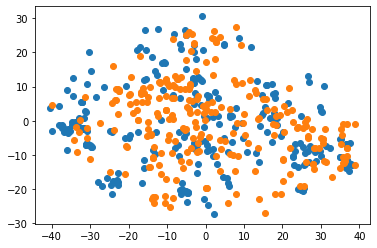

In [188]:
# print out the results to see if it makes sense now
plt.scatter(example_activation_1[:,0],example_activation_1[:,1])
plt.scatter(example_activation_2[:,0],example_activation_2[:,1])

In [194]:
# add the activations to the full df
df_full["bottleneck_tsne_embedding"] = activations_tsne_embedding_reshaped.tolist()
df_full["bottleneck_pca_embedding"] = activations_pca_embedding_reshaped.tolist()
df_full["bottleneck_umap_embedding"] = activations_umap_embedding_reshaped.tolist()

# overall_iou
df_full["overall_iou"] = combined_overall_iou

# iou by class
iou_class_df = pd.DataFrame(combined_iou_by_class,columns = ["other_iou","road_iou","sidewalk_iou","vegetation_iou","sky_iou","car_iou"])
df_full = pd.concat((df_full,iou_class_df),axis=1)

# paths of predictions
df_full["prediction_path"] = prediction_paths

Why is it that the points are not really separating?

In [196]:
# rearrange the columns in a fixed order
df_rearrange = df_full[['name','dataset', 'image_path', 'label_path','prediction_path', 'similar_image_paths','similar_IoU_score', 
                       'other_ratio', 'road_ratio', 'sidewalk_ratio','vegetation_ratio', 'sky_ratio', 'car_ratio', 
                       'simple_tsne_1','simple_tsne_2', 'meaningful_tsne_1', 'meaningful_tsne_2',"pca_1","pca_2",
       'bottleneck_tsne_embedding','bottleneck_pca_embedding','bottleneck_umap_embedding', 'overall_iou', 'other_iou',
       'road_iou', 'sidewalk_iou', 'vegetation_iou', 'sky_iou', 'car_iou']]

In [201]:
# drop duplicate columns
# df_rearrange = df_rearrange.loc[:,~df_rearrange.columns.duplicated()]

In [202]:
df_rearrange.columns

Index(['name', 'dataset', 'image_path', 'label_path', 'prediction_path',
       'similar_image_paths', 'similar_IoU_score', 'other_ratio', 'road_ratio',
       'sidewalk_ratio', 'vegetation_ratio', 'sky_ratio', 'car_ratio',
       'simple_tsne_1', 'simple_tsne_2', 'meaningful_tsne_1',
       'meaningful_tsne_2', 'pca_1', 'pca_2', 'bottleneck_tsne_embedding',
       'bottleneck_pca_embedding', 'bottleneck_umap_embedding', 'overall_iou',
       'other_iou', 'road_iou', 'sidewalk_iou', 'vegetation_iou', 'sky_iou',
       'car_iou'],
      dtype='object')

In [205]:
df_rearrange.to_csv("system_df_small_sample.csv",index=True)